<a href="https://colab.research.google.com/github/vineetsalar88/ResrachPaper2/blob/master/20Dec25Resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#dataset/
 └── images/
     ├── img001.jpg
     ├── img002.jpg
     ├── img003.jpg
     └── ...







image_name,label
img001.jpg,2
img002.jpg,0
img003.jpg,6


In [1]:
#Custom Dataset to read images + CSV
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset

class ImageCSVDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = int(self.data.iloc[idx, 1])

        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [2]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotationsResnet.csv")

class_map = {
    "Score 1": 0,
    "Score 2": 1,
    "Score 3": 2,
    "Score 4": 3,
    "Score 5": 4,
    "Score 6": 5,
    "Score 7": 6
}

df["label"] = df["label"].map(class_map)
df.to_csv("/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotationsImagenet.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotationsResnet.csv'

In [3]:
#Create Dataset & DataLoader
from torch.utils.data import DataLoader

dataset = ImageCSVDataset(
    csv_file="/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/annotationsImagenet.csv",
    image_dir="/content/drive/MyDrive/ResearchData/AnnonatedDataset17Dec25/Images",
    transform=transform
)

train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=2
)



In [4]:
#Load ResNet18 & freeze feature extractor
import torchvision.models as models
import torch.nn as nn

model = models.resnet18(pretrained=True)

# 🔒 Freeze all convolution layers
for param in model.parameters():
    param.requires_grad = False


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 73.6MB/s]


In [5]:
#Replace classifier for 7 classes
num_classes = 7
model.fc = nn.Linear(model.fc.in_features, num_classes)
for name, param in model.named_parameters():
    print(name, param.requires_grad)


conv1.weight False
bn1.weight False
bn1.bias False
layer1.0.conv1.weight False
layer1.0.bn1.weight False
layer1.0.bn1.bias False
layer1.0.conv2.weight False
layer1.0.bn2.weight False
layer1.0.bn2.bias False
layer1.1.conv1.weight False
layer1.1.bn1.weight False
layer1.1.bn1.bias False
layer1.1.conv2.weight False
layer1.1.bn2.weight False
layer1.1.bn2.bias False
layer2.0.conv1.weight False
layer2.0.bn1.weight False
layer2.0.bn1.bias False
layer2.0.conv2.weight False
layer2.0.bn2.weight False
layer2.0.bn2.bias False
layer2.0.downsample.0.weight False
layer2.0.downsample.1.weight False
layer2.0.downsample.1.bias False
layer2.1.conv1.weight False
layer2.1.bn1.weight False
layer2.1.bn1.bias False
layer2.1.conv2.weight False
layer2.1.bn2.weight False
layer2.1.bn2.bias False
layer3.0.conv1.weight False
layer3.0.bn1.weight False
layer3.0.bn1.bias False
layer3.0.conv2.weight False
layer3.0.bn2.weight False
layer3.0.bn2.bias False
layer3.0.downsample.0.weight False
layer3.0.downsample.1.weight Fa

In [6]:
#Loss & optimizer (only classifier trained)
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    model.fc.parameters(),  # 👈 only classifier
    lr=1e-3
)


In [7]:
train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,   # 🔴 ADD HERE (for debugging)
    pin_memory=False
)


In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
train_accuracies = []

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100.0 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Loss: {epoch_loss:.4f} | "
        f"Accuracy: {epoch_acc:.2f}%"
    )


Epoch [1/10] Loss: 1.4026 | Accuracy: 43.77%
Epoch [2/10] Loss: 1.2522 | Accuracy: 53.33%
Epoch [3/10] Loss: 1.1706 | Accuracy: 56.52%
Epoch [4/10] Loss: 1.1142 | Accuracy: 58.12%
Epoch [5/10] Loss: 1.0187 | Accuracy: 62.32%
Epoch [6/10] Loss: 1.0230 | Accuracy: 62.32%
Epoch [7/10] Loss: 0.9547 | Accuracy: 66.23%
Epoch [8/10] Loss: 0.9300 | Accuracy: 67.39%
Epoch [9/10] Loss: 0.8890 | Accuracy: 68.84%
Epoch [10/10] Loss: 0.8575 | Accuracy: 68.12%


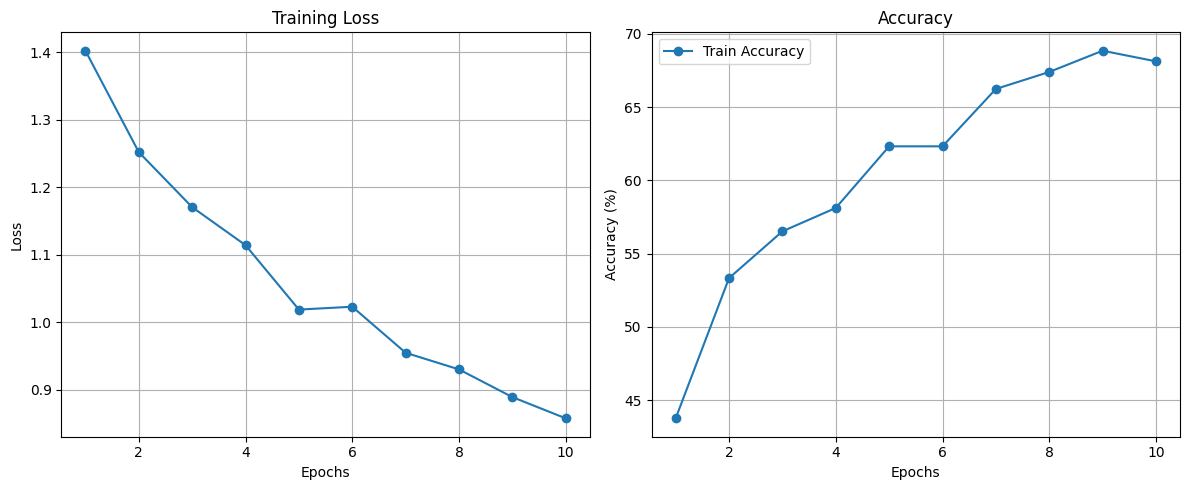

In [12]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# 🔹 LOSS
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

# 🔹 ACCURACY
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')

#if len(val_accuracies) > 0:
    #plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o')

plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


| Part               | Status             |
| ------------------ | ------------------ |
| ResNet Conv layers | ❄️ Frozen          |
| BatchNorm          | ❄️ Frozen          |
| FC layer           | 🔥 Trainable       |
| Optimizer          | FC parameters only |
